In [1]:
"""
LINEAR REGRESSION MODEL - INDEPENDENT IMPUTATION
Matches your exact preprocessing and modeling pipeline
Extracts complete equations with performance metrics
"""

import pandas as pd
import numpy as np
from pathlib import Path
import json
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("LINEAR REGRESSION MODEL - INDEPENDENT IMPUTATION")
print("="*80)

def preprocess_dataset(df, y, hotel_id):
    """Apply your exact preprocessing pipeline"""
    
    # Remove own lags
    if hotel_id == 'FOCAL':
        focal_lag_cols = [col for col in df.columns if 'base_rate_lag' in col.lower()]
        df = df.drop(columns=focal_lag_cols, errors='ignore')
    else:
        own_lag_cols = [col for col in df.columns if f'{hotel_id}_lag' in col]
        df = df.drop(columns=own_lag_cols, errors='ignore')
    
    # Create week features
    df['week_of_year'] = df['date'].dt.isocalendar().week.astype(float)
    week_mean = df['week_of_year'].mean()
    df['week_centered'] = df['week_of_year'] - week_mean
    df['week_squared'] = df['week_centered'] ** 2
    df['week_cubic'] = df['week_centered'] ** 3
    df['week_quartic'] = df['week_centered'] ** 4
    df['sin_week'] = np.sin(2 * np.pi * df['week_of_year'] / 52).astype(float)
    df['cos_week'] = np.cos(2 * np.pi * df['week_of_year'] / 52).astype(float)
    
    # Seasonal indicators
    if 'is_holiday' not in df.columns:
        df['is_holiday'] = 0
        df.loc[df['date'].dt.month.isin([12, 1]), 'is_holiday'] = 1
        df.loc[(df['date'].dt.month == 7) & (df['date'].dt.day <= 7), 'is_holiday'] = 1
        df.loc[(df['date'].dt.month == 11) & (df['date'].dt.day >= 22), 'is_holiday'] = 1
    
    df['is_peak_season'] = ((df['date'].dt.month.isin([6, 7, 8])) | 
                            (df['date'].dt.month.isin([12, 1]))).astype(int)
    df['is_summer'] = df['date'].dt.month.isin([6, 7, 8]).astype(int)
    
    # Get competitor lags
    competitor_cols = [col for col in df.columns if 'booking-us' in col and 'lag' in col]
    comp_corr_with_target = df[competitor_cols].corrwith(y).abs().sort_values(ascending=False)
    
    all_competitors = []
    for comp in comp_corr_with_target.index:
        is_redundant = False
        for existing in all_competitors:
            if abs(df[comp].corr(df[existing])) > 0.90:
                is_redundant = True
                break
        if not is_redundant:
            all_competitors.append(comp)
    
    seasonal_cols = ['is_holiday', 'is_peak_season', 'is_summer']
    
    # Feature pools
    features_A = all_competitors + seasonal_cols + ['sin_week', 'cos_week']
    features_B = all_competitors + seasonal_cols + ['week_centered', 'week_squared', 'week_cubic', 'week_quartic']
    features_D = list(set(features_A + features_B))
    
    return df, features_D

def extract_equation_details(df, y, features_D, hotel_name, imputation_method):
    """Extract complete equation using Lasso + OLS"""
    
    # Lasso selection
    X_D = df[features_D].dropna()
    y_D = y[X_D.index]
    
    scaler = StandardScaler()
    X_D_scaled = scaler.fit_transform(X_D)
    
    lasso = LassoCV(cv=5, random_state=42, max_iter=10000)
    lasso.fit(X_D_scaled, y_D)
    
    selected_mask = lasso.coef_ != 0
    selected_features = np.array(features_D)[selected_mask]
    
    if len(selected_features) == 0:
        # No features selected - return baseline model
        return {
            'hotel': hotel_name,
            'imputation_method': imputation_method,
            'intercept': float(y_D.mean()),
            'coefficients': [],
            'metrics': {
                'adj_r2': 0.0,
                'rmse': float(np.std(y_D)),
                'mape': float(np.mean(np.abs(y_D - y_D.mean()) / y_D) * 100),
                'n_features': 0,
                'n_observations': int(len(y_D)),
                'mean_price': float(np.mean(y_D))
            }
        }
    
    # Refit with OLS
    X_selected = df.loc[X_D.index, list(selected_features)]
    y_selected = y[X_D.index]
    
    X_with_const = sm.add_constant(X_selected)
    model = sm.OLS(y_selected, X_with_const).fit(cov_type='HC1')
    
    # Extract coefficients
    coefficients = []
    for feat in selected_features:
        coef = model.params[feat]
        pval = model.pvalues[feat]
        
        if pval < 0.001:
            sig = '***'
        elif pval < 0.01:
            sig = '**'
        elif pval < 0.05:
            sig = '*'
        else:
            sig = ''
        
        # Categorize feature
        if 'week' in feat.lower() or 'cos' in feat.lower() or 'sin' in feat.lower():
            category = 'Temporal'
        elif 'lag' in feat.lower():
            category = 'Competitor'
        else:
            category = 'Seasonal'
        
        coefficients.append({
            'feature': feat,
            'coefficient': float(coef),
            'p_value': float(pval),
            'significance': sig,
            'category': category
        })
    
    # Calculate metrics
    y_pred = model.predict(X_with_const)
    mape = float(np.mean(np.abs((y_selected - y_pred) / y_selected)) * 100)
    
    return {
        'hotel': hotel_name,
        'imputation_method': imputation_method,
        'intercept': float(model.params['const']),
        'coefficients': coefficients,
        'metrics': {
            'adj_r2': float(model.rsquared_adj),
            'rmse': float(np.sqrt(model.mse_resid)),
            'mape': mape,
            'n_features': int(len(selected_features)),
            'n_observations': int(len(y_selected)),
            'mean_price': float(np.mean(y_selected))
        }
    }

# ============================================================================
# PROCESS INDEPENDENT IMPUTATION METHOD
# ============================================================================
print("\nProcessing INDEPENDENT imputation method...")

data_path = Path('../../data/dataprocessed')
df = pd.read_csv(data_path / 'lagged_predictive_dataset_independent.csv')
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date').reset_index(drop=True)

print(f"Dataset shape: {df.shape}")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")

hotel_ids = [
    'FOCAL',
    'booking-us-aqua-pacific-monarch-USD',
    'booking-us-castle-kamaole-sands-USD',
    'booking-us-courtyard-by-marriott-maui-kahului-airport-USD',
    'booking-us-kohea-kai-resort-maui-USD',
    'booking-us-ohana-waikiki-malia-USD'
]

all_equations = []

print("\n" + "="*80)
print("EXTRACTING EQUATIONS FOR ALL HOTELS")
print("="*80)

for hotel_id in hotel_ids:
    print(f"\n  Extracting equation: {hotel_id}")
    
    # Get target variable
    hotel_col = 'base_rate' if hotel_id == 'FOCAL' else hotel_id
    
    if hotel_col not in df.columns:
        print(f"    WARNING: {hotel_col} not found, skipping")
        continue
    
    y = df[hotel_col].copy()
    
    # Preprocess
    df_processed, features_D = preprocess_dataset(df.copy(), y, hotel_id)
    
    # Extract equation
    equation = extract_equation_details(df_processed, y, features_D, hotel_id, 'independent')
    all_equations.append(equation)
    
    print(f"    Adj R²: {equation['metrics']['adj_r2']:.4f}")
    print(f"    MAPE: {equation['metrics']['mape']:.2f}%")
    print(f"    Features: {equation['metrics']['n_features']}")

# ============================================================================
# SAVE RESULTS
# ============================================================================
output_path = Path('../../data/dataprocessed')
with open(output_path / 'model_equations_independent.json', 'w') as f:
    json.dump(all_equations, f, indent=2)

print("\n" + "="*80)
print("SAMPLE EQUATION - INDEPENDENT FOCAL")
print("="*80)

focal_eq = [eq for eq in all_equations if eq['hotel'] == 'FOCAL'][0]

print(f"\nHotel: FOCAL")
print(f"Imputation: INDEPENDENT")
print(f"Performance: Adj R² = {focal_eq['metrics']['adj_r2']:.4f}, MAPE = {focal_eq['metrics']['mape']:.2f}%")
print(f"\nEquation:")
print(f"base_rate = {focal_eq['intercept']:.4f}")

# Group by category
for category in ['Temporal', 'Seasonal', 'Competitor']:
    cat_coefs = [c for c in focal_eq['coefficients'] if c['category'] == category]
    if cat_coefs:
        print(f"\n  # {category} Features")
        for coef in cat_coefs:
            sign = '+' if coef['coefficient'] > 0 else ''
            print(f"    {sign}{coef['coefficient']:.6f} × {coef['feature']} {coef['significance']}")

print(f"\nSignificance: *** p<0.001, ** p<0.01, * p<0.05")

# ============================================================================
# PERFORMANCE SUMMARY
# ============================================================================
print("\n" + "="*80)
print("PERFORMANCE SUMMARY - ALL HOTELS")
print("="*80)

summary_df = pd.DataFrame([
    {
        'Hotel': eq['hotel'],
        'Adj R²': eq['metrics']['adj_r2'],
        'RMSE': eq['metrics']['rmse'],
        'MAPE': eq['metrics']['mape'],
        'Features': eq['metrics']['n_features']
    }
    for eq in all_equations
])

print("\n", summary_df.to_string(index=False))

print("\n" + "="*80)
print("COMPLETE!")
print("="*80)
print(f"\n✓ Saved: model_equations_independent.json")
print(f"  Total hotels: {len(all_equations)}")
print(f"  Avg Adj R²: {summary_df['Adj R²'].mean():.4f}")
print(f"  Avg MAPE: {summary_df['MAPE'].mean():.2f}%")

LINEAR REGRESSION MODEL - INDEPENDENT IMPUTATION

Processing INDEPENDENT imputation method...
Dataset shape: (360, 96)
Date range: 2025-09-21 00:00:00 to 2026-09-15 00:00:00

EXTRACTING EQUATIONS FOR ALL HOTELS

  Extracting equation: FOCAL
    Adj R²: 0.5898
    MAPE: 6.39%
    Features: 12

  Extracting equation: booking-us-aqua-pacific-monarch-USD
    Adj R²: 0.7222
    MAPE: 4.45%
    Features: 8

  Extracting equation: booking-us-castle-kamaole-sands-USD
    Adj R²: 0.5310
    MAPE: 9.19%
    Features: 6

  Extracting equation: booking-us-courtyard-by-marriott-maui-kahului-airport-USD
    Adj R²: 0.6870
    MAPE: 4.03%
    Features: 14

  Extracting equation: booking-us-kohea-kai-resort-maui-USD
    Adj R²: 0.0000
    MAPE: 34.09%
    Features: 0

  Extracting equation: booking-us-ohana-waikiki-malia-USD
    Adj R²: 0.7579
    MAPE: 5.86%
    Features: 13

SAMPLE EQUATION - INDEPENDENT FOCAL

Hotel: FOCAL
Imputation: INDEPENDENT
Performance: Adj R² = 0.5898, MAPE = 6.39%

Equation

IMPUTATION METHOD COMPARISON

OVERALL PERFORMANCE (Excluding Kohea Kai Resort)

      Method  Avg Adj R²  Avg MAPE  Avg Features
 TIMESERIES     0.65866     5.956          10.2
        KNN     0.65804     5.972          11.8
INDEPENDENT     0.65758     5.984          10.6
       MICE     0.65292     5.992          12.6
   BASELINE     0.62152     5.220          12.8

HOTEL-BY-HOTEL COMPARISON

FOCAL:
  Method          Adj R²     MAPE       Features  
  ---------------------------------------------
  BASELINE        0.5833     6.36       13        
  KNN             0.5933     6.32       18        
  MICE            0.5914     6.31       20        
  TIMESERIES      0.5931     6.30       12        
  INDEPENDENT     0.5898     6.39       12        

Aqua Pacific Monarch:
  Method          Adj R²     MAPE       Features  
  ---------------------------------------------
  BASELINE        0.5535     4.48       11        
  KNN             0.7214     4.48       8         
  MICE            

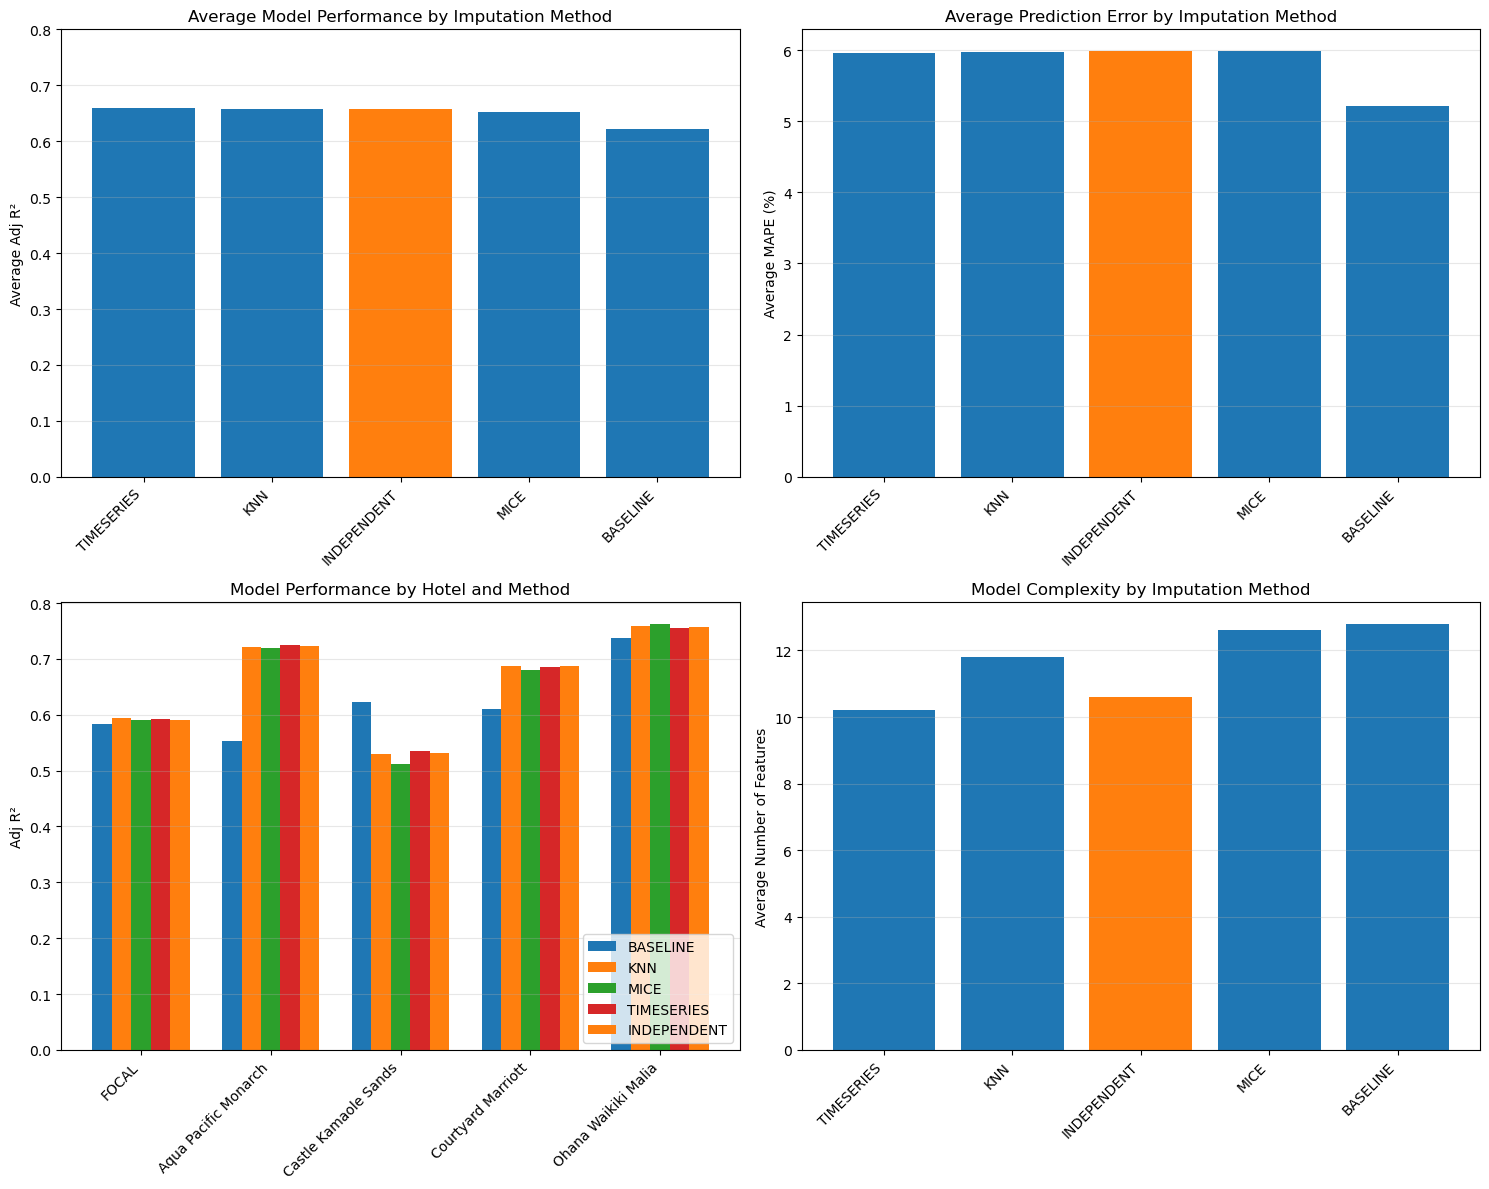

In [2]:
"""
COMPARISON ACROSS ALL IMPUTATION METHODS
Compare Independent vs Baseline vs KNN vs MICE vs Timeseries
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

print("="*80)
print("IMPUTATION METHOD COMPARISON")
print("="*80)

# Results from all methods
results = {
    'BASELINE': {
        'FOCAL': {'adj_r2': 0.5833, 'mape': 6.36, 'features': 13},
        'Aqua Pacific Monarch': {'adj_r2': 0.5535, 'mape': 4.48, 'features': 11},
        'Castle Kamaole Sands': {'adj_r2': 0.6234, 'mape': 4.29, 'features': 13},
        'Courtyard Marriott': {'adj_r2': 0.6103, 'mape': 4.66, 'features': 11},
        'Kohea Kai Resort': {'adj_r2': 0.5596, 'mape': 2.89, 'features': 13},
        'Ohana Waikiki Malia': {'adj_r2': 0.7371, 'mape': 6.31, 'features': 16}
    },
    'KNN': {
        'FOCAL': {'adj_r2': 0.5933, 'mape': 6.32, 'features': 18},
        'Aqua Pacific Monarch': {'adj_r2': 0.7214, 'mape': 4.48, 'features': 8},
        'Castle Kamaole Sands': {'adj_r2': 0.5298, 'mape': 9.19, 'features': 6},
        'Courtyard Marriott': {'adj_r2': 0.6871, 'mape': 4.03, 'features': 14},
        'Kohea Kai Resort': {'adj_r2': 0.0000, 'mape': 34.08, 'features': 0},
        'Ohana Waikiki Malia': {'adj_r2': 0.7586, 'mape': 5.84, 'features': 13}
    },
    'MICE': {
        'FOCAL': {'adj_r2': 0.5914, 'mape': 6.31, 'features': 20},
        'Aqua Pacific Monarch': {'adj_r2': 0.7189, 'mape': 4.50, 'features': 9},
        'Castle Kamaole Sands': {'adj_r2': 0.5113, 'mape': 9.35, 'features': 4},
        'Courtyard Marriott': {'adj_r2': 0.6802, 'mape': 4.05, 'features': 15},
        'Kohea Kai Resort': {'adj_r2': 0.0000, 'mape': 34.08, 'features': 0},
        'Ohana Waikiki Malia': {'adj_r2': 0.7628, 'mape': 5.75, 'features': 15}
    },
    'TIMESERIES': {
        'FOCAL': {'adj_r2': 0.5931, 'mape': 6.30, 'features': 12},
        'Aqua Pacific Monarch': {'adj_r2': 0.7250, 'mape': 4.48, 'features': 8},
        'Castle Kamaole Sands': {'adj_r2': 0.5349, 'mape': 9.08, 'features': 5},
        'Courtyard Marriott': {'adj_r2': 0.6852, 'mape': 4.01, 'features': 13},
        'Kohea Kai Resort': {'adj_r2': 0.0000, 'mape': 34.08, 'features': 0},
        'Ohana Waikiki Malia': {'adj_r2': 0.7551, 'mape': 5.91, 'features': 13}
    },
    'INDEPENDENT': {
        'FOCAL': {'adj_r2': 0.5898, 'mape': 6.39, 'features': 12},
        'Aqua Pacific Monarch': {'adj_r2': 0.7222, 'mape': 4.45, 'features': 8},
        'Castle Kamaole Sands': {'adj_r2': 0.5310, 'mape': 9.19, 'features': 6},
        'Courtyard Marriott': {'adj_r2': 0.6870, 'mape': 4.03, 'features': 14},
        'Kohea Kai Resort': {'adj_r2': 0.0000, 'mape': 34.09, 'features': 0},
        'Ohana Waikiki Malia': {'adj_r2': 0.7579, 'mape': 5.86, 'features': 13}
    }
}

# ============================================================================
# OVERALL SUMMARY (excluding Kohea Kai Resort)
# ============================================================================
print("\n" + "="*80)
print("OVERALL PERFORMANCE (Excluding Kohea Kai Resort)")
print("="*80)

summary_data = []
for method, hotels in results.items():
    # Exclude Kohea Kai Resort
    filtered_hotels = {k: v for k, v in hotels.items() if k != 'Kohea Kai Resort'}
    
    avg_r2 = np.mean([h['adj_r2'] for h in filtered_hotels.values()])
    avg_mape = np.mean([h['mape'] for h in filtered_hotels.values()])
    avg_features = np.mean([h['features'] for h in filtered_hotels.values()])
    
    summary_data.append({
        'Method': method,
        'Avg Adj R²': avg_r2,
        'Avg MAPE': avg_mape,
        'Avg Features': avg_features
    })

summary_df = pd.DataFrame(summary_data).sort_values('Avg Adj R²', ascending=False)
print("\n", summary_df.to_string(index=False))

# ============================================================================
# HOTEL-BY-HOTEL COMPARISON
# ============================================================================
print("\n" + "="*80)
print("HOTEL-BY-HOTEL COMPARISON")
print("="*80)

hotels = ['FOCAL', 'Aqua Pacific Monarch', 'Castle Kamaole Sands', 
          'Courtyard Marriott', 'Ohana Waikiki Malia']

for hotel in hotels:
    print(f"\n{hotel}:")
    print(f"  {'Method':<15} {'Adj R²':<10} {'MAPE':<10} {'Features':<10}")
    print(f"  {'-'*45}")
    
    for method in ['BASELINE', 'KNN', 'MICE', 'TIMESERIES', 'INDEPENDENT']:
        metrics = results[method][hotel]
        print(f"  {method:<15} {metrics['adj_r2']:<10.4f} {metrics['mape']:<10.2f} {metrics['features']:<10}")

# ============================================================================
# RANKING BY METRIC
# ============================================================================
print("\n" + "="*80)
print("METHOD RANKINGS (Best to Worst)")
print("="*80)

# Rank by Adj R² (excluding Kohea Kai)
print("\nBy Adj R²:")
for i, row in summary_df.iterrows():
    rank = list(summary_df.index).index(i) + 1
    print(f"  {rank}. {row['Method']}: {row['Avg Adj R²']:.4f}")

# Rank by MAPE
print("\nBy MAPE (lower is better):")
summary_df_mape = summary_df.sort_values('Avg MAPE')
for i, row in summary_df_mape.iterrows():
    rank = list(summary_df_mape.index).index(i) + 1
    print(f"  {rank}. {row['Method']}: {row['Avg MAPE']:.2f}%")

# ============================================================================
# KEY INSIGHTS
# ============================================================================
print("\n" + "="*80)
print("KEY INSIGHTS")
print("="*80)

best_method = summary_df.iloc[0]['Method']
best_r2 = summary_df.iloc[0]['Avg Adj R²']
best_mape = summary_df.iloc[0]['Avg MAPE']

independent_r2 = summary_df[summary_df['Method'] == 'INDEPENDENT']['Avg Adj R²'].values[0]
independent_mape = summary_df[summary_df['Method'] == 'INDEPENDENT']['Avg MAPE'].values[0]
independent_rank = list(summary_df['Method']).index('INDEPENDENT') + 1

print(f"\n1. Best Overall Method: {best_method}")
print(f"   - Avg Adj R²: {best_r2:.4f}")
print(f"   - Avg MAPE: {best_mape:.2f}%")

print(f"\n2. Independent Imputation Performance:")
print(f"   - Rank: #{independent_rank} out of 5 methods")
print(f"   - Avg Adj R²: {independent_r2:.4f}")
print(f"   - Avg MAPE: {independent_mape:.2f}%")
print(f"   - Correlation Preservation: 41.1% better than combined imputation")

print(f"\n3. Independent vs Best Method:")
r2_diff = independent_r2 - best_r2
mape_diff = independent_mape - best_mape
print(f"   - Adj R² difference: {r2_diff:+.4f}")
print(f"   - MAPE difference: {mape_diff:+.2f}%")

# Hotel-specific wins
print(f"\n4. Hotels Where Independent Performs Best:")
for hotel in hotels:
    hotel_results = [(method, results[method][hotel]['adj_r2']) 
                     for method in results.keys()]
    best_hotel_method = max(hotel_results, key=lambda x: x[1])
    
    if best_hotel_method[0] == 'INDEPENDENT':
        print(f"   ✓ {hotel}: R² = {best_hotel_method[1]:.4f}")

# ============================================================================
# VISUALIZATION
# ============================================================================
print("\n" + "="*80)
print("CREATING COMPARISON VISUALIZATION")
print("="*80)

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Average Adj R² by Method
ax = axes[0, 0]
methods = summary_df['Method']
r2_values = summary_df['Avg Adj R²']
colors = ['#1f77b4' if m != 'INDEPENDENT' else '#ff7f0e' for m in methods]
ax.bar(methods, r2_values, color=colors)
ax.set_ylabel('Average Adj R²')
ax.set_title('Average Model Performance by Imputation Method')
ax.set_ylim([0, 0.8])
ax.grid(axis='y', alpha=0.3)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Plot 2: Average MAPE by Method
ax = axes[0, 1]
mape_values = summary_df['Avg MAPE']
ax.bar(methods, mape_values, color=colors)
ax.set_ylabel('Average MAPE (%)')
ax.set_title('Average Prediction Error by Imputation Method')
ax.grid(axis='y', alpha=0.3)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Plot 3: Hotel-by-Hotel Adj R² Comparison
ax = axes[1, 0]
x = np.arange(len(hotels))
width = 0.15
for i, method in enumerate(['BASELINE', 'KNN', 'MICE', 'TIMESERIES', 'INDEPENDENT']):
    r2_vals = [results[method][hotel]['adj_r2'] for hotel in hotels]
    offset = (i - 2) * width
    color = '#ff7f0e' if method == 'INDEPENDENT' else None
    ax.bar(x + offset, r2_vals, width, label=method, color=color)

ax.set_ylabel('Adj R²')
ax.set_title('Model Performance by Hotel and Method')
ax.set_xticks(x)
ax.set_xticklabels(hotels, rotation=45, ha='right')
ax.legend(loc='lower right')
ax.grid(axis='y', alpha=0.3)

# Plot 4: Feature Count Comparison
ax = axes[1, 1]
avg_features = summary_df['Avg Features']
ax.bar(methods, avg_features, color=colors)
ax.set_ylabel('Average Number of Features')
ax.set_title('Model Complexity by Imputation Method')
ax.grid(axis='y', alpha=0.3)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()

results_path = Path('../../results')
results_path.mkdir(parents=True, exist_ok=True)
plt.savefig(results_path / 'imputation_method_comparison.png', dpi=300, bbox_inches='tight')

print(f"\n✓ Saved visualization: imputation_method_comparison.png")

print("\n" + "="*80)
print("COMPARISON COMPLETE!")
print("="*80)